# 图像插值算法(Interpolation)

## 何为插值?

一个图片从**4×4** 放大到**8*8**的时候， 就会产生一些**新的像素点**（ 如下图红点所示），

如何给这些值赋值， 就是`interpolation` 插值所要解决的问题。

![chazhi-01.png](./img/chazhi-01.png)

## 插值方法一览

全部的插值方式 请见文档 [InterpolationFlags](https://docs.opencv.org/master/da/d54/group__imgproc__transform.html#ga5bb5a1fea74ea38e1a5445ca803ff121)

这里我们只讲解五个插值方式。 我们随机生成一个5×5的矩阵， 然后用下面五种方式进行插值， 效果如图所示：

![chazhi-all.png](./img/chazhi-all.png)

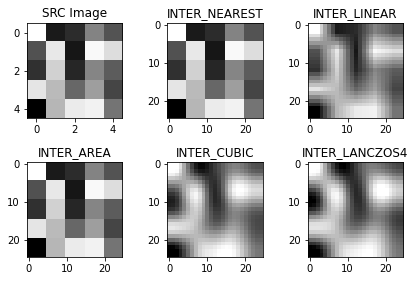

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


img = np.uint8(np.random.randint(0,255,size=(5,5)))
height,width= img.shape


# 声明新的维度
new_dimension = (25, 25)

plt.subplot(231)
plt.title("SRC Image")
plt.imshow(img,cmap='gray')

plt.subplot(232)
resized = cv2.resize(img, new_dimension, interpolation = cv2.INTER_NEAREST)
plt.title("INTER_NEAREST")
plt.imshow(resized,cmap='gray')


plt.subplot(233)
resized = cv2.resize(img, new_dimension, interpolation = cv2.INTER_LINEAR)
plt.title("INTER_LINEAR")
plt.imshow(resized,cmap='gray')


plt.subplot(234)
resized = cv2.resize(img, new_dimension, interpolation = cv2.INTER_AREA)
plt.title("INTER_AREA")
plt.imshow(resized,cmap='gray')


plt.subplot(235)
resized = cv2.resize(img, new_dimension, interpolation = cv2.INTER_CUBIC)
plt.title("INTER_CUBIC")
plt.imshow(resized,cmap='gray')


plt.subplot(236)
resized = cv2.resize(img, new_dimension, interpolation = cv2.INTER_LANCZOS4)
plt.title("INTER_LANCZOS4")
plt.imshow(resized,cmap='gray')
plt.tight_layout() 
plt.show()

为了更加直观的观察，我们将 `cmap` 换为 `seismic` 分辨率 从 5*5 放大到 1000 * 1000
![chazhi-02.png](./img/chazhi-02.png)

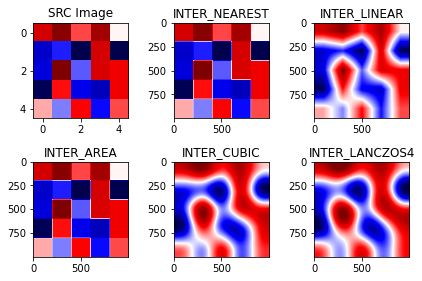

In [2]:
img = np.uint8(np.random.randint(0,255,size=(5,5)))
height,width= img.shape


# 声明新的维度
new_dimension = (1000, 1000)

plt.subplot(231)
plt.title("SRC Image")
plt.imshow(img,cmap='seismic')

plt.subplot(232)
resized = cv2.resize(img, new_dimension, interpolation = cv2.INTER_NEAREST)
plt.title("INTER_NEAREST")
plt.imshow(resized,cmap='seismic')


plt.subplot(233)
resized = cv2.resize(img, new_dimension, interpolation = cv2.INTER_LINEAR)
plt.title("INTER_LINEAR")
plt.imshow(resized,cmap='seismic')


plt.subplot(234)
resized = cv2.resize(img, new_dimension, interpolation = cv2.INTER_AREA)
plt.title("INTER_AREA")
plt.imshow(resized,cmap='seismic')


plt.subplot(235)
resized = cv2.resize(img, new_dimension, interpolation = cv2.INTER_CUBIC)
plt.title("INTER_CUBIC")
plt.imshow(resized,cmap='seismic')


plt.subplot(236)
resized = cv2.resize(img, new_dimension, interpolation = cv2.INTER_LANCZOS4)
plt.title("INTER_LANCZOS4")
plt.imshow(resized,cmap='seismic')
plt.tight_layout() 
plt.show()

关于插值方式的不同与缩放因子的不同对应的时间消耗， 可以查阅下表：

![](./img/speedtest.png)

## 最近邻插值 INTER_NEAREST

最近邻插值法， 找到与之距离最相近的邻居（原来就存在的像素点， 黑点）， 赋值与其相同。

![](./img/inner-nearst.gif)


![](./img/chazhi-05.png)

**效果展示**

![](./img/chazhi-06.png)


In [3]:
def nn_interpolate(img, ax=1, ay=1):
    H, W, C = img.shape
    aH = int(ay * H)
    aW = int(ax * W)
    y = np.arange(aH).repeat(aW).reshape(aW, -1)
    x = np.tile(np.arange(aW), (aH, 1))
    y = np.round(y / ay).astype(np.int)
    x = np.round(x / ax).astype(np.int)

    out = img[y, x]

    out = out.astype(np.uint8)

    return out

In [14]:
img = cv2.imread("./img/imori.jpg").astype(np.float32)

# Nearest Neighbor
out = nn_interpolate(img, ax=1.5, ay=1.5)
cv2.imshow("result", out)
cv2.waitKey(0)
cv2.destroyAllWindows()

## 线性插值（**默认**）INTER_LINEAR

这里的线形插值`INTER_LINEAR` 其实是`Bi-Linear Interpolation`(双线性插值)

双线性插值考察邻域的像素点，并根据距离设置权值。虽然计算量增大使得处理时间变长，但是可以有效抑制画质劣化

我们先来看一个简单的**一维线形插值**的例子。

已知两点（红色） ，在给出一个蓝点的x坐标， 求y。

所以需要根据两个红点确定一条直线，求出直线的表达式， 然后再将x坐标带进去。

![](./img/chazhi-08.png)

接下来我们来看`Bi-Linear Interpolation` 的例子。

![](./img/chazhi-09.png)


双线性插值考察$4$邻域的像素点，并根据距离设置权值。虽然计算量增大使得处理时间变长，但是可以有效抑制画质劣化。

1. 放大后图像的座标$(x',y')$除以放大率$a$，可以得到对应原图像的座标$(\lfloor \frac{x'}{a}\rfloor , \lfloor \frac{y'}{a}\rfloor)$。

2. 求原图像的座标$(\lfloor \frac{x'}{a}\rfloor , \lfloor \frac{y'}{a}\rfloor)$周围$4$邻域的座标$I(x,y)$，$I(x+1,y)$，$I(x,y+1)$，$I(x+1, y+1)$：
   
   <img src="assets/bli_fig.png">
   
3. 分别求这4个点与$(\frac{x'}{a}, \frac{y'}{a})$的距离，根据距离设置权重：$w = \frac{d}{\sum\ d}$

4. 根据下式求得放大后图像$(x',y')$处的像素值：
$$
d_x = \frac{x'}{a} - x\\
  d_y = \frac{y'}{a} - y\\
  I'(x',y') = (1-d_x)\  (1-d_y)\  I(x,y) + d_x\  (1-d_y)\  I(x+1,y) + (1-d_x)\  d_y\  I(x,y+1) + d_x\  d_y\  I(x+1,y+1)
$$

**效果展示**

![chazhi-12.png](./img/chazhi-12.png)

In [6]:
# Bi-Linear interpolation
def bl_interpolate(org_img, ax=1., ay=1.):
    H, W, C = org_img.shape

    aH = int(ay * H)
    aW = int(ax * W)

    # get position of resized image
    y = np.arange(aH).repeat(aW).reshape(aW, -1)
    x = np.tile(np.arange(aW), (aH, 1))

    # get position of original position
    y = (y / ay)
    x = (x / ax)

    ix = np.floor(x).astype(np.int)
    iy = np.floor(y).astype(np.int)

    ix = np.minimum(ix, W - 2)
    iy = np.minimum(iy, H - 2)

    # get distance 
    dx = x - ix
    dy = y - iy

    dx = np.repeat(np.expand_dims(dx, axis=-1), 3, axis=-1)
    dy = np.repeat(np.expand_dims(dy, axis=-1), 3, axis=-1)

    # interpolation
    out = (1 - dx) * (1 - dy) * org_img[iy, ix] + dx * (1 - dy) * org_img[iy, ix + 1] + (1 - dx) * dy * org_img[
        iy + 1, ix] + dx * dy * org_img[iy + 1, ix + 1]

    out = np.clip(out, 0, 255)
    out = out.astype(np.uint8)

    return out

In [9]:
img = cv2.imread("./img/imori.jpg").astype(np.float32)

# Bilinear interpolations
# out = bl_interpolate(img, ax=1.5, ay=1.5)
out = bl_interpolate(img, ax=9, ay=9)

cv2.imshow("result", out)
cv2.waitKey(0)
cv2.destroyAllWindows()

## 区域插值 INTER_AREA

![chazhi-13.png](./img/chazhi-13.png)

## 三次样条插值 INTER_CUBIC

![chazhi-14.png](./img/chazhi-14.png)

由相邻的4*4像素计算得出，公式类似于双线性.

## Lanczos插值 INTER_LANCZOS4

![chazhi-15.png](./img/chazhi-15.png)

兰索斯插值：由相邻的8*8像素计算得出，公式类似于双线性